#Gradient Symbolic Computation & Incremental Processing

Pyeong Whan Cho (pcho4@jhu.edu)

Department of Cognitive Science, Johns Hopkins University

In [1]:
%matplotlib inline
%run ../gsc2
%run ../grammar

##Example 1: Bifurcation in the GSC network

We investigate a simple artificial language which was designed to reveal two important computational problems arising in incremental processing. To help understanding the model, we introduce several concepts from dynamical systems theory without formal definitions. 

In [2]:
# For now, the grammar.py does not support the itemification of the rewrite rules.
# We will itemify the rules manually. Depending on the maximal sentence length, 
# manual itemification can take long. 
# To make the model minimal, we ignore unused span roles. 
# Also, we ignore the unary rules (e.g., S -> S[1]).

# Itemification of the rewrite rules (Harmonic Normal Form) to a sentence length 2.
# S[1]/R[0,1,2] -> A/R[0,1] B/R[1,2]
# S[2]/R[0,1,2] -> A/R[0,1] C/R[1,2]
# S[3]/R[0,1,2] -> D/R[0,1] B/R[1,2]
# S[4]/R[0,1,2] -> D/R[0,1] C/R[1,2]

# Harmonic Grammar
# H(S[1]/R[0,1,2], A/R[0,1]) = 2
# H(S[1]/R[0,1,2], B/R[1,2]) = 2

role_names = ['R[0,1,2]', 'R[0,1]', 'R[1,2]']
filler_names = ['S[1]', 'S[2]', 'S[3]', 'S[4]', 'A', 'B', 'C', 'D', '_']
# '_' is used for a null filler symbol

# Specify a list of grid points as reference points.
# When it is provided as the grid_points argument of the GscNet, 
# the program will compute the (by-default) Euclidean distance of the state from 
# each of the reference points at every timestep.
# Each element itself is a list of f/r bindings representing a contituent structure. 
sentence_types = [['S[1]/R[0,1,2]', 'A/R[0,1]', 'B/R[1,2]'], 
                  ['S[2]/R[0,1,2]', 'A/R[0,1]', 'C/R[1,2]'],
                  ['S[3]/R[0,1,2]', 'D/R[0,1]', 'B/R[1,2]'],
                  ['S[4]/R[0,1,2]', 'D/R[0,1]', 'C/R[1,2]']]

net = GscNet(filler_names=filler_names, role_names=role_names, 
             reptype_r='dist', reptype_f='dist', beta=10.0, grid_points=sentence_types)

# Set the weights and biases based on the itemified harmonic grammar rules.
# Between-constituents harmony
net.set_weight('S[1]/R[0,1,2]', ['A/R[0,1]', 'B/R[1,2]'], 2.0)  # H(S[1]/R[0,1,2], A/R[0,1]) = 2.0
                                                                # H(S[1]/R[0,1,2], B/R[1,2]) = 2.0 
net.set_weight('S[2]/R[0,1,2]', ['A/R[0,1]', 'C/R[1,2]'], 2.0)  # H(S[2]/R[0,1,2], A/R[0,1]) = 2.0
                                                                # H(S[2]/R[0,1,2], C/R[1,2]) = 2.0
net.set_weight('S[3]/R[0,1,2]', ['D/R[0,1]', 'B/R[1,2]'], 2.0)  # H(S[3]/R[0,1,2], D/R[0,1]) = 2.0
                                                                # H(S[3]/R[0,1,2], B/R[1,2]) = 2.0
net.set_weight('S[4]/R[0,1,2]', ['D/R[0,1]', 'C/R[1,2]'], 2.0)  # H(S[4]/R[0,1,2], D/R[0,1]) = 2.0
                                                                # H(S[4]/R[0,1,2], C/R[1,2]) = 2.0
# Individual constituent harmony
net.set_filler_bias(['S[1]', 'S[2]', 'S[3]', 'S[4]'], -2.0)     # H(S[1]/R) = H(S[2]/R) = H(S[3]/R) = 
                                                                # H(S[4]/R) = -2.0 (needs two legal daughters)
net.set_filler_bias(['A', 'B', 'C', 'D'], -1.0)                 # H(A/R) = H(B/R) = H(C/R) = H(D/R) = -1.0
                                                                # (needs a legal mother)
net.set_filler_bias('_', 0.0)                                   # H(_/R) = 0.0

# The [beta] parameter is the bowl strength. 
# if the bowl center is to be inside the unit hypercube in the conceptual space, 
# its value should be greather than a certain value (beta min) 
# which depends on weights, bias values, and external input.
# So whenever weights, bias values, and external input are changed, 
# run check_beta() to check if the current beta value is greater than beta min.
net.check_beta(disp=True)

Recommended beta min = 8.000


Activation state trace in the conceptual (local) space:


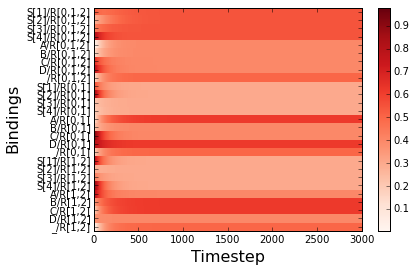

Euclidean distance trace in the neural (distributed) space:


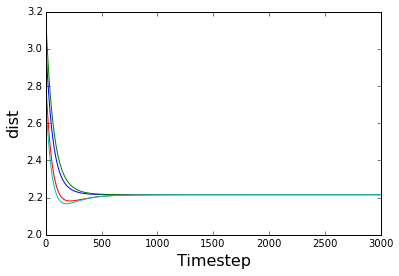

The end state is:
      R[0,1,2]    R[0,1]    R[1,2]
S[1]  0.547620  0.300000  0.300000
S[2]  0.547620  0.300000  0.300000
S[3]  0.547619  0.300000  0.300000
S[4]  0.547619  0.300000  0.300000
A     0.400000  0.619048  0.400000
B     0.400000  0.400000  0.619048
C     0.400000  0.400000  0.619048
D     0.400000  0.619048  0.400000
_     0.500000  0.500000  0.500000


In [3]:
# To understand the model better, first, we will use a rather unusual T and q update scheuldes.
# First, let us set T_init, T, and T_decay_rate to 0.0; then, the model is a deterministic dynamical system.
# Second, set q_init, q_rate, q to 0.0 as well. We ignore quantization dynamics.
net.T = 0.             # current T value
net.T_init = 0.        # initial value of T
net.T_decay_rate = 0.  # decay rate: T(timestep+1) = T_decay_rate * (T(timestep) - T_min) (by default, T_min = 0)
net.q = 0.             # current q value
net.q_init = 0.        # initial value of q
net.q_rate = 0.        # rate of change: when q_fun is set to 'plinear' (default), 
                       # q(timestep+1) = q(timestep) + q_rate
np.random.seed(100)    # For reproducibility, fix a random seed. 
                       # Computer internal clock can be used as seed number.
net.reset()            # Reset the state to a random vector in the unit hypercube in conceptual coordinates;
                       # reset q and T to their initial values; unclamp all f/r bindings; clear all external input

print('Activation state trace in the conceptual (local) space:')
net.run(3000, plot=True)

print('Euclidean distance trace in the neural (distributed) space:') # CHECK
net.plot_trace('dist')

print('The end state is:')
net.read_state()

The plots suggest that the model converged to a state. We call it an equilibrium point (or fixed point); once the state is set to an equilibrium point, the system does not change and stay there forever. Moreover, in this example, the state seems to be attracting. We can test if the state is attracting by adding a small random noise to the current state and then allowing the model to update its state. 

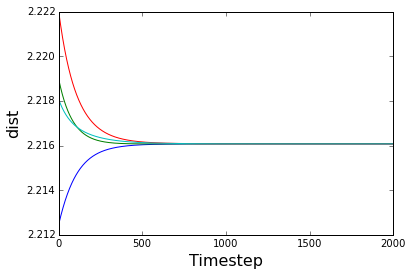

The end state is:
      R[0,1,2]    R[0,1]    R[1,2]
S[1]  0.547620  0.300000  0.300000
S[2]  0.547620  0.300000  0.300000
S[3]  0.547619  0.300000  0.300000
S[4]  0.547620  0.300000  0.300000
A     0.400000  0.619048  0.400000
B     0.400000  0.400000  0.619048
C     0.400000  0.400000  0.619048
D     0.400000  0.619048  0.400000
_     0.500000  0.500000  0.500000


In [4]:
# Add a small gaussian noise to the current state in neural coordinates
# and then update the state
net.act = net.act + 0.01 * np.random.randn(net.nunits)
net.run(2000, plot=False)   # the default heatmap is not good for small activation changes
net.plot_trace('dist')
print('The end state is:')
net.read_state()

The model converged to the equilibrium point again. This type of equilibrium point is called an *attractor* (or *sink*) (see the lecture slides). For an attractor, we can think of a set of states that will move to the attractor. This set of states is called a *basin of attraction*. In the GSC model, they correspond to the the top of each hump in harmony landscape. When $q = 0$, the GSC network has a single global optimum; the harmony surface has a single peak. Thus, even if a very large noise is added to the current state, the system will converge to the equilibrium point in the long run.

We interpret the end state as a blend of four different sentences. Notice that in each role, not all fillers are equally activated. This is because some f/r bindings (e.g., A/R[0,1,2]) do not receive support from others while other f/r bindings (e.g., S[1]/R[0,1,2]) receive support from others (their mothers or their daughters; e.g., A/R[0,1] and B/R[1,2]). 

Now imagine what will happen if $q$ increases; remember that a non-zero $q$ introduces competition among fillers in each role. You can see ungrammatical f/r bindings cannot be a winner in the competition (when no noise is added [T = 0]) because they are less activated than grammatical f/r bindings. For example, in $R[0,1,2]$, A, B, C, D, _ cannot be a winner. In a highly noisy situation, this does not hold. In a mildly noisy situation, not all grid points (poles) won't be chosen. Now let us change $q$ gradually and slowly.

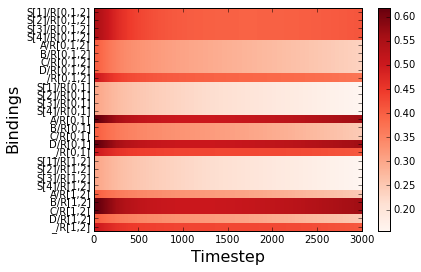

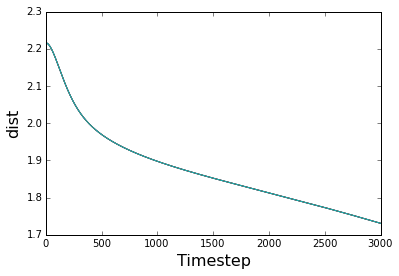

      R[0,1,2]    R[0,1]    R[1,2]
S[1]  0.413277  0.155897  0.155897
S[2]  0.413278  0.155897  0.155897
S[3]  0.413277  0.155898  0.155898
S[4]  0.413277  0.155898  0.155898
A     0.234006  0.566383  0.245594
B     0.234006  0.245594  0.566382
C     0.234006  0.245594  0.566383
D     0.234007  0.566382  0.245594
_     0.369205  0.406756  0.406756


In [5]:
net.q_rate = 0.005       # Set q_rate to 0.005; q will increase by 0.005 every timestep. (q_fun: 'plinear')
#net.reset()             # DO NOT RESET the state. 
                         # The initial state at this time would be the end state of the previous simulation.
net.run(3000, plot=True)
net.plot_trace('dist')
net.read_state()

With the $q$ change, the equilibrium state has moved to a new equilibrium point.

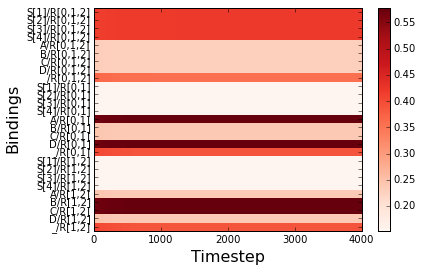

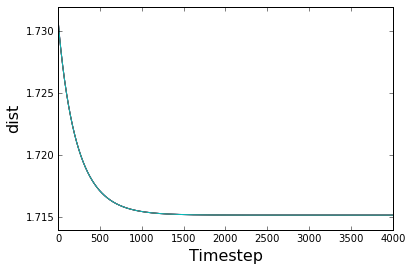

      R[0,1,2]    R[0,1]    R[1,2]
S[1]  0.420458  0.152732  0.152732
S[2]  0.420459  0.152732  0.152732
S[3]  0.420457  0.152733  0.152732
S[4]  0.420457  0.152732  0.152732
A     0.227784  0.578347  0.238052
B     0.227784  0.238052  0.578346
C     0.227784  0.238052  0.578347
D     0.227784  0.578346  0.238052
_     0.356549  0.389309  0.389309


In [6]:
net.q_rate = 0.          # Keep the current q value.
#net.reset()             # DO NOT RESET the state. 
                         # The initial state at this time would be the end state of the previous simulation.
net.run(4000, plot=True)
net.plot_trace('dist')
net.read_state()

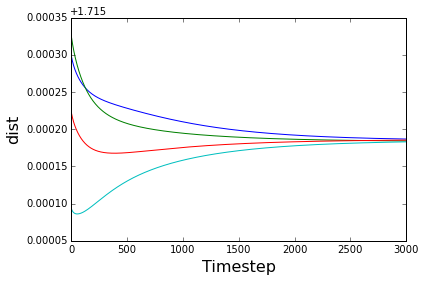

The end state is:
      R[0,1,2]    R[0,1]    R[1,2]
S[1]  0.420456  0.152732  0.152732
S[2]  0.420458  0.152732  0.152732
S[3]  0.420457  0.152733  0.152732
S[4]  0.420459  0.152732  0.152732
A     0.227784  0.578346  0.238052
B     0.227784  0.238052  0.578345
C     0.227784  0.238052  0.578348
D     0.227784  0.578347  0.238052
_     0.356549  0.389309  0.389309


In [7]:
# Add a small gaussian noise to the current state in neural coordinates
# and then update the state
net.act = net.act + 0.0001 * np.random.randn(net.nunits)
net.run(3000, plot=False)   # the default heatmap is not good for small activation changes
net.plot_trace('dist')
print('The end state is:')
net.read_state()

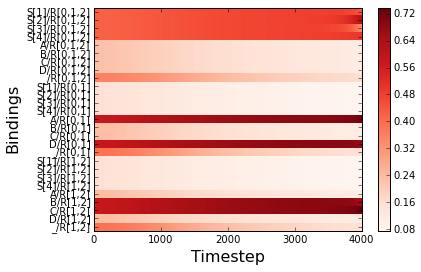

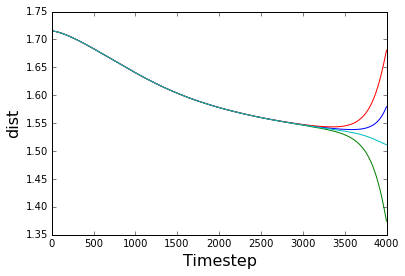

      R[0,1,2]    R[0,1]    R[1,2]
S[1]  0.426711  0.074999  0.075068
S[2]  0.641997  0.074999  0.075068
S[3]  0.318595  0.074999  0.075068
S[4]  0.501143  0.074999  0.075068
A     0.112802  0.723684  0.108463
B     0.112802  0.108349  0.650284
C     0.112802  0.108350  0.738140
D     0.112802  0.666892  0.108463
_     0.158995  0.150383  0.150572


In [8]:
# Use the same q udpate schedule.
net.q_rate = 0.005          # reset q_rate to 0.005
net.run(4000, plot=True)
net.plot_trace('dist')
net.read_state()

When $q$ becomes greater than a certain value, there is a qualitative change in the harmony landscape. Now the landscape has multiple (in this example, four) basins of attraction each of which is associated with a sentence. So even with a very small precision error, the state quickly moves away from the balanced blend state and toward one of the grammatical grid point. This change is called $\textit{bifurcation}$ and the parameter (in the current example, $q$) that introduces this kind of qualitative change is called $\textit{control parameter}$. It is possible to analyze bifurcation more accurately by using specialized software (e.g., <a href="http://sourceforge.net/projects/cocotools/">COCO</a>).

Now let us investigate what happens when the model receives external input. We will present a sentence A B sequentially, one word at a time, and check if the system can build the target constituent structure, {S[1]/R[0,1,2], A/R[0,1], B/R[1,2]}. Notice that this is not an easy task because the second word is consistent with both S[1] and S[3] so the model needs memory to keep what it has processed with the first word input. Word input will be modeled by external input supporting a target constituent. Harmony landscape changes whenever new word input is presented to the model.

Recommended beta min = 8.000


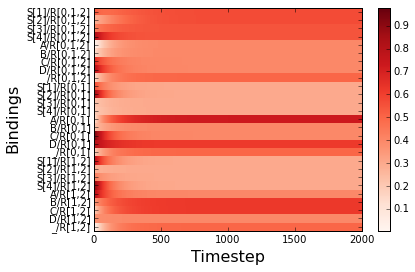

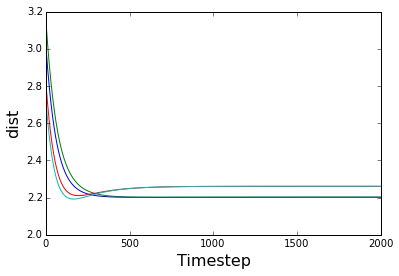

In [11]:
# T and q are fixed at 0 as before.
net.T = 0.
net.T_init = 0.
net.T_decay_rate = 0.
net.q = 0.
net.q_rate = 0.
np.random.seed(100)
net.reset()                     # For new simulation, reset the state.
net.set_input('A/R[0,1]', 1.0)  # Provide external input supporting the binding A/R[0,1] in conceptual coordinates.
                                # The magnitude can be any number.
net.check_beta(disp=True)
net.run(2000, plot=True)
net.plot_trace('dist')

In [10]:
net.read_state()

      R[0,1,2]    R[0,1]    R[1,2]
S[1]  0.570393  0.300000  0.300000
S[2]  0.570393  0.299999  0.300000
S[3]  0.548654  0.300000  0.300000
S[4]  0.548654  0.300000  0.300000
A     0.400000  0.728157  0.400000
B     0.400000  0.400000  0.623809
C     0.400000  0.400000  0.623809
D     0.400000  0.619461  0.400000
_     0.500000  0.500000  0.500000


The system converges to an equilibrium point which is a blend of four sentences. Because A/R[0,1] is receiving external input, the constituent is more strongly activated than D/R[0,1]. In the role R[0,1,2], S[1] and S[2] are more strongly activated than S[3] and S[4] because they receive supporting signal from A/R[0,1]. We can say the model prefers S1 and S2 to S3 and S4. If we increase $q$ at this state with no noise (T = 0), S[3] and S[4] cannot be a winner in the competition in the role R[0,1,2]. 

Now we can remove the first word and then provide the second word input to the model. Again, $T$ and $q$ are fixed to 0.

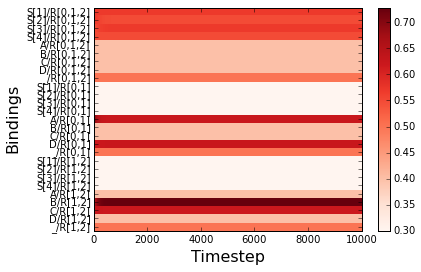

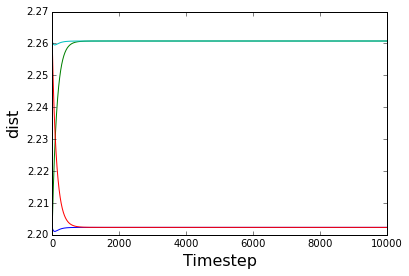

      R[0,1,2]   R[0,1]    R[1,2]
S[1]  0.570394  0.30000  0.300000
S[2]  0.548655  0.30000  0.300000
S[3]  0.570394  0.30000  0.300000
S[4]  0.548655  0.30000  0.300000
A     0.400000  0.62381  0.400000
B     0.400000  0.40000  0.728158
C     0.400000  0.40000  0.619462
D     0.400000  0.62381  0.400000
_     0.500000  0.50000  0.500000


In [12]:
net.set_input('B/R[1,2]', 1.0)
net.run(10000, plot=True)
net.plot_trace('dist')
net.read_state()

With the new word input, the system converged to a new equilbrium point. As in the previous case, the equilibrium point is a blend of four sentences. At this time, however, S1 and S3 are more weighted than S2 and S4; S[1] and S[3] are more strongly activated than S[2] and S[4] in the R[0,1,2] because they receive supporting signal from B/R[1,2] which receives supporting signal from external input. Notice that in a sense, the model lost what it had processed. Given the first word, the model should prefer S[1] to S[3] in the R[0,1,2] but it didn't. 

One solution would be to provide cumulative external input; in other words, when the second word is presented, we can present both words A and B. But it is a quesiton how a system can keep the input in this way. We propose that by controlling $q$ appropriately, the model can correctly build the target structure without losing the information from the first word. 

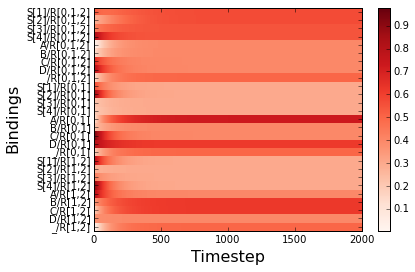

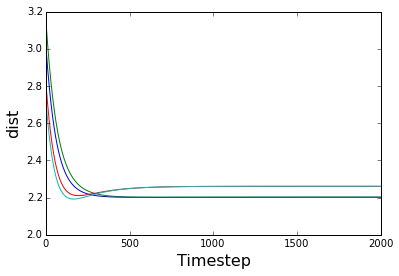

      R[0,1,2]    R[0,1]    R[1,2]
S[1]  0.570393  0.300000  0.300000
S[2]  0.570393  0.299999  0.300000
S[3]  0.548654  0.300000  0.300000
S[4]  0.548654  0.300000  0.300000
A     0.400000  0.728157  0.400000
B     0.400000  0.400000  0.623809
C     0.400000  0.400000  0.623809
D     0.400000  0.619461  0.400000
_     0.500000  0.500000  0.500000


In [59]:
# Input A
net.T = 0.
net.T_init = 0.
net.T_decay_rate = 0.
net.q = 0.
net.q_rate = 0.
np.random.seed(100)             # Repeat the first step: Run the model with the first word input (T=0 and q=0)
net.reset()
net.set_input('A/R[0,1]', 1.0)
net.run(2000, plot=True)
net.plot_trace('dist')
net.read_state()

Before presenting the second word, we will increase $q$.

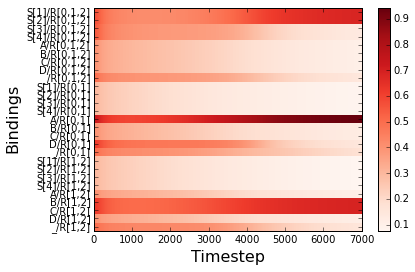

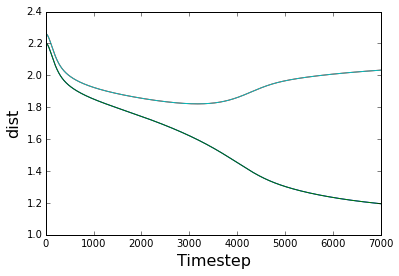

      R[0,1,2]    R[0,1]    R[1,2]
S[1]  0.687191  0.081751  0.075806
S[2]  0.687194  0.081750  0.075806
S[3]  0.132333  0.081751  0.075806
S[4]  0.132333  0.081751  0.075806
A     0.106057  0.943873  0.109786
B     0.106057  0.120670  0.693502
C     0.106057  0.120670  0.693506
D     0.106057  0.146860  0.109786
_     0.146271  0.175437  0.153098


In [60]:
net.q_rate = 0.005         # Set q_rate to a non-zero value. Now q will change over time in this rate. 
                           # q(timestep+1) = q(timestep) + q_rate (when q_fun is set to 'plinear' or 'linear')
#net.run(10000, plot=True)
net.run(7000, plot=True)
net.plot_trace('dist')
net.read_state()

The model disprefers impossible structures (S3 and S4) given the current input (A/R[0,1]) more strongly. When $q$ becomes greater than a certain value (Getting its estimate requires more careful bifurcation analysis), bifurcation happened; in the current setting, there are multiple attractors. To show it, we set the initial state to a particular grid point corresponding to an ideal S3 representation and then run the model. 

Now two possible sentences are seprated from the other two impossible sentences. 

In [61]:
# Before setting the state to a new position, backup the current state. 
# Later we don't need to repeat the same process before presenting the second word input.
state_backup = copy.deepcopy(net.act)

New initial state:
          R[0,1,2]        R[0,1]        R[1,2]
S[1] -6.245005e-17  1.088539e-16 -1.040834e-16
S[2]  6.036838e-16  5.666041e-16 -2.740863e-16
S[3]  1.000000e+00  1.509209e-16  2.255141e-16
S[4]  3.608225e-16 -3.937822e-16 -3.330669e-16
A    -4.857226e-17  1.483189e-16 -1.665335e-16
B    -2.775558e-17  1.049508e-16  1.000000e+00
C     2.775558e-17 -1.708703e-16  5.551115e-17
D     2.775558e-17  1.000000e+00  4.163336e-17
_     1.387779e-17  9.367507e-17  2.775558e-17


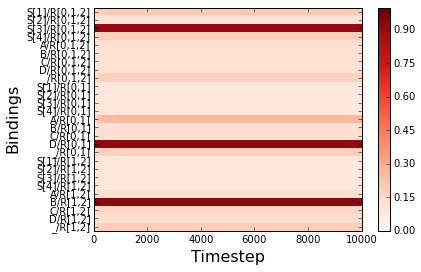

      R[0,1,2]    R[0,1]    R[1,2]
S[1]  0.201212  0.083260  0.084611
S[2]  0.112403  0.083260  0.084611
S[3]  0.908623  0.083260  0.084610
S[4]  0.183086  0.083260  0.084611
A     0.119770  0.255126  0.126153
B     0.119770  0.123499  0.928616
C     0.119770  0.123499  0.158596
D     0.119770  0.912972  0.126153
_     0.173031  0.181654  0.188354


In [65]:
# Set the activation state of a set of constituents to 1.
net.set_state(['S[3]/R[0,1,2]', 'D/R[0,1]', 'B/R[1,2]'])
print('New initial state:')
net.read_state()

net.q_rate = 0.               # Set q_rate to 0. 
net.run(10000, plot=True)
print('New end state:')
net.read_state()

The model converged to a different equilibrium point (in this case, attractor) when the initial state was set to a grid point corresponding to the ideal representation of S3. At this level of $q$, the harmony landscape has multiple humps (basins of attraction) separated by valleys---$\textit{harmony barrier}$. Now check if the previous end state is an attractor. 

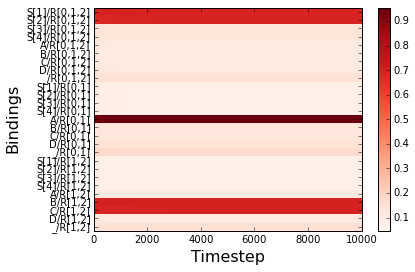

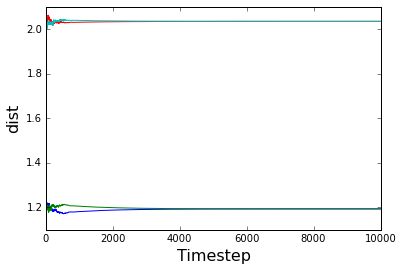

      R[0,1,2]    R[0,1]    R[1,2]
S[1]  0.687836  0.081431  0.075462
S[2]  0.687829  0.081431  0.075462
S[3]  0.131190  0.081431  0.075462
S[4]  0.131189  0.081431  0.075462
A     0.105435  0.944686  0.109125
B     0.105435  0.119991  0.693895
C     0.105435  0.119991  0.693886
D     0.105435  0.145242  0.109125
_     0.145036  0.173521  0.151681


In [63]:
net.act = copy.deepcopy(state_backup)  # Set the state to the previous end state.
net.T = 0.01                           # Instead of adding random noise to the current state one time, 
net.T_decay_rate = 0.01                # we can set T to a non-zero value and update it.
net.run(10000, plot=True)
net.plot_trace('dist')
net.read_state()

When the model was perturbed with small noise, it seemed to return to the previous end state. Thus, the backuped state seems to be an attractor. (Caution: This is not an exact investigation. Near the saddle point, the rate of change can be very small so the system may look staying at a point.) 

Now let us investigate what happens when a large noise is added. 

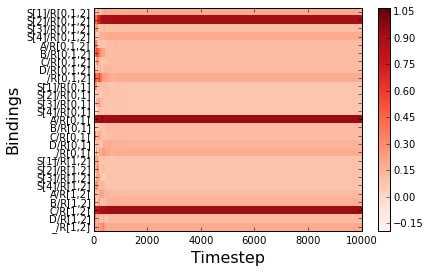

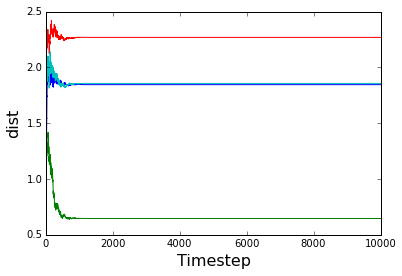

      R[0,1,2]    R[0,1]    R[1,2]
S[1]  0.187496  0.082526  0.084675
S[2]  0.911707  0.082526  0.084675
S[3]  0.104130  0.082526  0.084675
S[4]  0.184807  0.082526  0.084675
A     0.119967  0.938997  0.126281
B     0.119967  0.122079  0.158317
C     0.119967  0.122079  0.928375
D     0.119967  0.151303  0.126281
_     0.173468  0.178275  0.188691


In [67]:
net.act = copy.deepcopy(state_backup)  # Set the state to the previous end state.
net.T = 0.8                            # Add a large noise
net.T_decay_rate = 0.01
net.run(10000, plot=True)
net.plot_trace('dist')
net.read_state()

At this time, the model converged to a new equilibrium point corresponding to S2. The topology of the attractors is presented below. The figure shows topology of harmony landscape when $q$ = 35. (The below figure was created by running more careful bifurcation analysis with a model with local representation. Due to precision issues, the equilibrium points from the above simulation may differ slightly from the equilibrium points in the below figure.)

<img src="images/gramAmbi-inputA-gamma35.png", height=300px>

Now set q_rate, T, and T_decay_rate to 0 again and present the second word alone to the model.

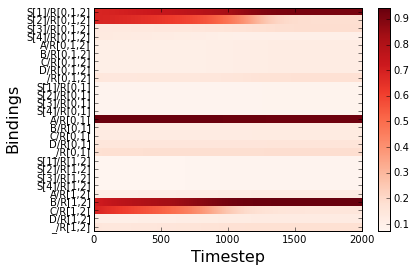

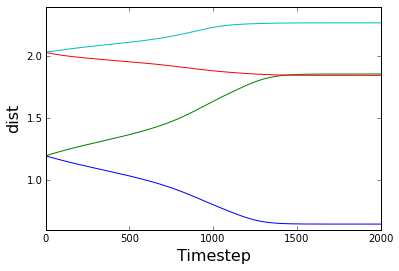

      R[0,1,2]    R[0,1]    R[1,2]
S[1]  0.911707  0.084675  0.082526
S[2]  0.184818  0.084675  0.082526
S[3]  0.187491  0.084675  0.082526
S[4]  0.104131  0.084675  0.082526
A     0.119967  0.928376  0.122079
B     0.119967  0.126281  0.938996
C     0.119967  0.126281  0.151307
D     0.119967  0.158315  0.122079
_     0.173467  0.188689  0.178275


In [69]:
net.act = copy.deepcopy(state_backup)   # Set the state to the previous end state after processing A.
net.T = 0.
net.T_decay_rate = 0.
net.q_rate = 0.
net.set_input('B/R[1,2]', 1.0)
net.run(2000, plot=True)
net.plot_trace('dist')
net.read_state()

The model correctly built the target representation of the sentence from sequentially presented words. This is because after processing the first word with increasing $q$, the state will be more likely to be in the basins of the blend of S1 and S2 (or S1 and S2 if T is not 0) which are separated from the basins of S3 and S4 by deep harmony barriers. The new word input 'B/R[1,2]' changes harmony landscape so S3 is as good as S1. However, the state is close to the basin of S1 so the model will converge to S1. 

<img src="images/gramAmbi-inputB-gamma35.png", height=300px>

The investigation of the model's behavior suggests that in principle, the model can build a target constituent structure from sequentially presented input. Finally, we run the model in more reasonable way below. $q$ will be set to 0 at the beginning and then increase over time in a fixed rate. Temperature is fixed to a small value (T = 0.005). Due to this noise, the model won't converge to a blend state at which S1 and S2 are perfectly balanced. However, the state will be still close to S1 and S2. When the second word is presented, the region close to S2 becomes unstable---the region goes down in the harmony space. 

In [109]:
params = {'testvar': 'ema_speed',            # exponential moving average speed
          'norm_ord': np.inf,                # np.inf: speed is defined as max(abs(act(timestep) - act(timestep-1)))
                                             # this is good because it is not sensitive to the number of units.
                                             # set it to 2 to use Euclidean distance when computing speed.
          'convergence_check': True,         # True: when [testvar] becomes smaller than [tol], 
                                             # stop updating the state and read the next word.
          'dist_space': 'S',                 # Distance (state change) will be computed in neural coordinates.
          'tol': 1e-3, 
          'ema_factor': 0.1,                 # ema_speed(timestep) = ema_factor * ema_speed(timestep-1) + 
                                             #                       (1 - ema_factor) * speed(timestep)
          'grid_points': sentence_types, 
          'input_method': 'ext',             # ext vs. clamp: for comprehension, choose 'ext'.
          'cumulative_input': False,         # False: present one word at a time.
          'input_inhib': False,              # Do not suppress other competitors in the same role.
          'update_T': True,                  # Not meaning because T_decay_rate is set to 0.
          'update_q': True, 
          'maxstep': np.array([2000, 3000]), # Maximal time step for each word input (a numpy array)
          'nrep': 1,                         # Number of repetitions
          'q_fun': 'plinear',                # Piecewise linear
          'ext_overlap': True,               # The actual n-th external input = 
                                             #    alpha * (n-1)-th external input + 
                                             #    (1 - alpha) * (n)-th external input
                                             #    where alpha changes over [ext_overlap_steps] from 1 to 0.
                                             # True: harmony landscape will change gradually.
          'ext_overlap_steps': 1000} 

net.reset()
net.T_init = 0.001
net.T_decay_rate = 0.0
net.q_rate = 0.02

input_list = ['A/R[0,1]', 'B/R[1,2]']
net.reset()
sim1 = sim(net, params)
input_vals = [1.0, 1.0]
sim1.input_list = input_list
sim1.input_vals = input_vals

Activation state change in conceptual coordinates:


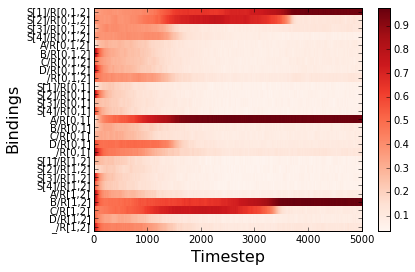


The end state after processing the first word (A)
      R[0,1,2]    R[0,1]    R[1,2]
S[1]  0.654447  0.077712  0.065058
S[2]  0.733000  0.074704  0.066604
S[3]  0.104621  0.074635  0.065031
S[4]  0.115435  0.065361  0.065105
A     0.096744  0.957164  0.097168
B     0.095272  0.108405  0.633130
C     0.094960  0.116861  0.755512
D     0.094374  0.116877  0.087401
_     0.133142  0.154969  0.120230

The end state after processing the second word (B)
      R[0,1,2]    R[0,1]    R[1,2]
S[1]  0.958766  0.065734  0.057373
S[2]  0.121553  0.056183  0.061682
S[3]  0.123351  0.065416  0.061242
S[4]  0.063422  0.065274  0.053583
A     0.088773  0.964284  0.098912
B     0.085849  0.080398  0.967523
C     0.089061  0.085081  0.095493
D     0.080428  0.099748  0.086707
_     0.113046  0.115503  0.111208

The distance change:

The end state after processing the current sentence "A B":
['S[1]/R[0,1,2]', 'A/R[0,1]', 'B/R[1,2]']
None


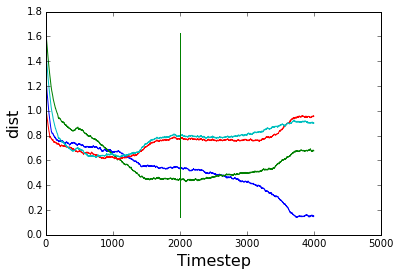

In [114]:
sim1.simulate()
print('Activation state change in conceptual coordinates:')
sim1.plot_act_trace(rep_num=1)
print('\nThe end state after processing the first word (A)')
sim1.read_state(rep_num=1, word_num=1)
print('\nThe end state after processing the second word (B)')
sim1.read_state(1, 2)
print('\nThe distance change:')
sim1.plot_trace('dist', 1)
print('\nThe end state after processing the current sentence "A B":')
print(sim1.read_grid_point(rep_num=1, word_num=2))